In [82]:
%load_ext autoreload
%autoreload 2

import ot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
data_path = '/home/nelosegui/BIFOLD_work/domain_generalisation/conv_eeg/simpleconv_datasets'
model_path = '/home/nelosegui/BIFOLD_work/domain_generalisation/conv_eeg/results'

## Load the data example


In [58]:
from scripts.scripts import *

p          = [0.2,160,4,70,5] #0th element corresponds to the temperature parameter for the learning rate
dict_config = { 
'wass_reg':True,
'model':'EEGSimpleConv',
'params':p,
'dataset':'BNCI',
'runs':5,
'n_epochs':50,
'EA':True,
'mixup':True,
'BN':True,
'EOG':False,
'Z':'Z0',
'path':data_path,
'lmso':False,
'session':True,
'reg_subject':True,
'use_wandb':True,
'evaluation':'cross',
'comment':'baseline',
'within':False,
'mdl':False,
'filter':0.5,
'save_model':True,
'save_model_path':'/home/nelosegui/BIFOLD_work/domain_generalisation/conv_eeg/results/BNCI_subj_reg',
'load_model':False,
'preload_reg':False,
'online':False
}    
    
    
X,Y = load_data(dict_config)

Sampling Freq: 250


## Data explanation for BNCI

Batch data is organized in a list of (torch.tensor(data), torch.tensor(class_label), torch.tensor(subject_label))
- torch.tensor(data) = (n_trails per session, n_channels, n_timepoints (Hz * seconds))
- torch.tensor (class_label): (n_traisls)
    - all subjects have the same order of class labels except:
    - subj 8,5,0 (session 0) and 3 (session 1) are different from the rest but the same among eachother
    - subj 3 session 0 is different from all the rest

- torch.tensor(subject): (n_trials) consecutive batches are from the same subject (i.e. 0 and 1, 2 and 3, etc.). Each batch per subject corresponds to a different session

## Arrange the data to pass into the pre-trained model.
Divide into classes and subjects to find the barycenter


In [59]:
train_loader, test_loader = loaders(3,X,Y,dict_config['lmso'],5,dict_config['session'],dict_config['reg_subject'], wass_reg = True, within=dict_config['within'],mdl=dict_config['mdl'])

## Funciton that loads pairs of batches of data, aligns thieir classes and computes a distance

In [60]:
#ensure each batch contains data from 1 subject and 1 session (do not shuffle)

for batch_idx, batch_data in enumerate(train_loader):
    print('batch_idx', batch_idx)
    print('batch_subject', torch.unique(batch_data[2]))
    print('batch_data', torch.unique(batch_data[1]))


batch_idx 0
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
batch_idx 1
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
batch_idx 2
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
batch_idx 3
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
batch_idx 4
batch_subject tensor([2])
batch_data tensor([0, 1, 2, 3])
batch_idx 5
batch_subject tensor([2])
batch_data tensor([0, 1, 2, 3])
batch_idx 6
batch_subject tensor([4])
batch_data tensor([0, 1, 2, 3])
batch_idx 7
batch_subject tensor([4])
batch_data tensor([0, 1, 2, 3])
batch_idx 8
batch_subject tensor([5])
batch_data tensor([0, 1, 2, 3])
batch_idx 9
batch_subject tensor([5])
batch_data tensor([0, 1, 2, 3])
batch_idx 10
batch_subject tensor([6])
batch_data tensor([0, 1, 2, 3])
batch_idx 11
batch_subject tensor([6])
batch_data tensor([0, 1, 2, 3])
batch_idx 12
batch_subject tensor([7])
batch_data tensor([0, 1, 2, 3])
batch_idx 13
batch_subject tensor([7])
batch_data tensor([0, 1, 2, 3])
batch_idx 14
bat

Separate into classes

In [61]:
from collections import defaultdict
import torch

len(train_loader), len(test_loader)

for batch_idx, batch_data in enumerate(train_loader):
    print('batch_idx', batch_idx)
    print('batch_subject', torch.unique(batch_data[2]))
    print('batch_data', torch.unique(batch_data[1]))

    # Separate batch data into sub-batches based on class labels
    class_labels = batch_data[1]
    sub_batches = defaultdict(list)

    for i, label in enumerate(class_labels):
        sub_batches[label.item()].append(batch_data[0][i])

    # Convert lists to tensors
    for label in sub_batches:
        sub_batches[label] = torch.stack(sub_batches[label])

    # Print sub-batches for verification
    for label, sub_batch in sub_batches.items():
        print(f'Class label: {label}, Sub-batch size: {sub_batch.size()}')

batch_idx 0
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
Class label: 3, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 0, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 2, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 1, Sub-batch size: torch.Size([72, 22, 1001])
batch_idx 1
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
Class label: 1, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 2, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 0, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 3, Sub-batch size: torch.Size([72, 22, 1001])
batch_idx 2
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
Class label: 1, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 2, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 0, Sub-batch size: torch.Size([72, 22, 1001])
Class label: 3, Sub-batch size: torch.Size([72, 22, 1001])
batch_idx 3
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
Class label:

In [72]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt

# Initialize dictionary to store accumulated sub-batches for each class label
accumulated_sub_batches = defaultdict(list)

# Iterate through each batch
for batch_idx, batch_data in enumerate(train_loader):
    print('batch_idx', batch_idx)
    print('batch_subject', torch.unique(batch_data[2]))
    print('batch_data', torch.unique(batch_data[1]))

    # Separate batch data into sub-batches based on class labels
    class_labels = batch_data[1]
    sub_batches = defaultdict(list)

    for i, label in enumerate(class_labels):
        sub_batches[label.item()].append(batch_data[0][i])

    # Convert lists to tensors and accumulate sub-batches
    for label in sub_batches:
        sub_batches[label] = torch.stack(sub_batches[label])
        accumulated_sub_batches[label].append(sub_batches[label])

batch_idx 0
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
batch_idx 1
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
batch_idx 2
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
batch_idx 3
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
batch_idx 4
batch_subject tensor([2])
batch_data tensor([0, 1, 2, 3])
batch_idx 5
batch_subject tensor([2])
batch_data tensor([0, 1, 2, 3])
batch_idx 6
batch_subject tensor([4])
batch_data tensor([0, 1, 2, 3])
batch_idx 7
batch_subject tensor([4])
batch_data tensor([0, 1, 2, 3])
batch_idx 8
batch_subject tensor([5])
batch_data tensor([0, 1, 2, 3])
batch_idx 9
batch_subject tensor([5])
batch_data tensor([0, 1, 2, 3])
batch_idx 10
batch_subject tensor([6])
batch_data tensor([0, 1, 2, 3])
batch_idx 11
batch_subject tensor([6])
batch_data tensor([0, 1, 2, 3])
batch_idx 12
batch_subject tensor([7])
batch_data tensor([0, 1, 2, 3])
batch_idx 13
batch_subject tensor([7])
batch_data tensor([0, 1, 2, 3])
batch_idx 14
bat

In [75]:
accumulated_sub_batches.keys(), len(accumulated_sub_batches)

(dict_keys([3, 0, 2, 1]), 4)

In [66]:
sub_batch.shape

torch.Size([72, 22, 1001])

## Instantiate the pre-trained model

In [53]:
best_params = dict_config['params']

dict_config['params'] = best_params
dict_config,params_model = correct_dict_1(dict_config,best_params)

model = instanciate_model(dict_config['model'],params_model)


In [67]:
# Plot the sub-batches for each class label
for label, sub_batches in accumulated_sub_batches.items():
    for i, sub_batch in enumerate(sub_batches):
        plt.figure(figsize=(10, 5))
        plt.title(f'Sub-batch {i} for class label {label}')
        plt.imshow(sub_batch.mean(dim=0).numpy(), cmap='viridis')
        plt.colorbar()
        plt.show()

output,output_subject, latent = model(sub_batch)

/home/nelosegui/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


batch_idx 0
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
batch_idx 1
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
batch_idx 2
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
batch_idx 3
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
batch_idx 4
batch_subject tensor([2])
batch_data tensor([0, 1, 2, 3])
batch_idx 5
batch_subject tensor([2])
batch_data tensor([0, 1, 2, 3])
batch_idx 6
batch_subject tensor([4])
batch_data tensor([0, 1, 2, 3])
batch_idx 7
batch_subject tensor([4])
batch_data tensor([0, 1, 2, 3])
batch_idx 8
batch_subject tensor([5])
batch_data tensor([0, 1, 2, 3])
batch_idx 9
batch_subject tensor([5])
batch_data tensor([0, 1, 2, 3])
batch_idx 10
batch_subject tensor([6])
batch_data tensor([0, 1, 2, 3])
batch_idx 11
batch_subject tensor([6])
batch_data tensor([0, 1, 2, 3])
batch_idx 12
batch_subject tensor([7])
batch_data tensor([0, 1, 2, 3])
batch_idx 13
batch_subject tensor([7])
batch_data tensor([0, 1, 2, 3])
batch_idx 14
bat

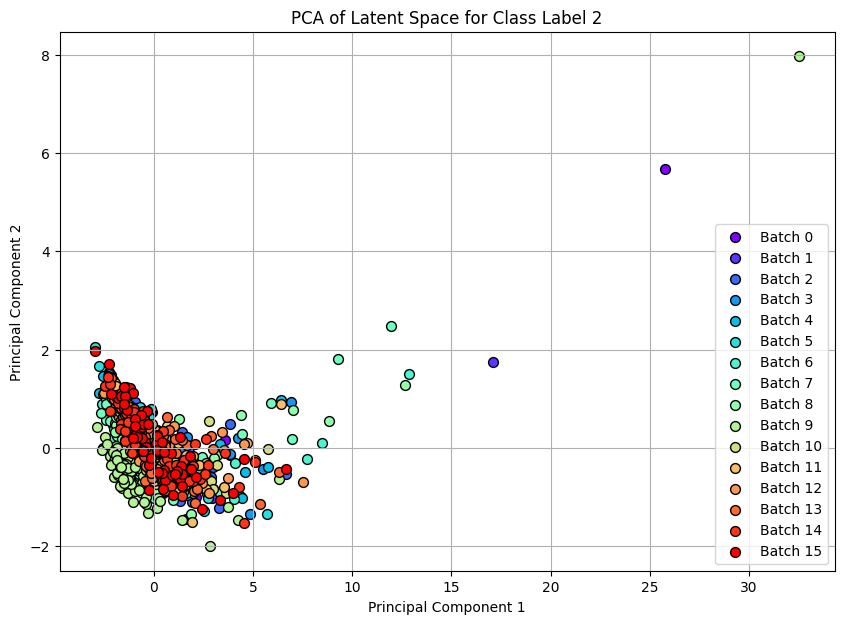

Total variance explained by PCA for Batch 0: 0.61
Total variance explained by PCA for Batch 1: 0.43
Total variance explained by PCA for Batch 2: 0.27
Total variance explained by PCA for Batch 3: 0.35
Total variance explained by PCA for Batch 4: 0.33
Total variance explained by PCA for Batch 5: 0.27
Total variance explained by PCA for Batch 6: 0.48
Total variance explained by PCA for Batch 7: 0.50
Total variance explained by PCA for Batch 8: 0.46
Total variance explained by PCA for Batch 9: 0.77
Total variance explained by PCA for Batch 10: 0.27
Total variance explained by PCA for Batch 11: 0.26
Total variance explained by PCA for Batch 12: 0.32
Total variance explained by PCA for Batch 13: 0.27
Total variance explained by PCA for Batch 14: 0.33
Total variance explained by PCA for Batch 15: 0.30


<Figure size 640x480 with 0 Axes>

In [86]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Initialize dictionary to store accumulated sub-batches for each class label
accumulated_sub_batches = defaultdict(list)
accumulated_latents = defaultdict(list)
batch_indices = defaultdict(list)

# Iterate through each batch
for batch_idx, batch_data in enumerate(train_loader):
    print('batch_idx', batch_idx)
    print('batch_subject', torch.unique(batch_data[2]))
    print('batch_data', torch.unique(batch_data[1]))

    # Separate batch data into sub-batches based on class labels
    class_labels = batch_data[1]
    sub_batches = defaultdict(list)

    for i, label in enumerate(class_labels):
        sub_batches[label.item()].append(batch_data[0][i])

    # Convert lists to tensors and accumulate sub-batches
    for label in sub_batches:
        sub_batches[label] = torch.stack(sub_batches[label])
        accumulated_sub_batches[label].append(sub_batches[label])
        batch_indices[label].append(batch_idx)

# Compute the model latent for each sub-batch and accumulate latents for a given class
given_class_label = 2  # Change this to the desired class label
for label, sub_batches in accumulated_sub_batches.items():
    for i, sub_batch in enumerate(sub_batches):
        output, output_subject, latent = model(sub_batch)
        accumulated_latents[label].append(latent)

# Perform PCA on the accumulated latents for the given class
if given_class_label in accumulated_latents:
    latents = torch.cat(accumulated_latents[given_class_label], dim=0).detach().numpy()
    pca = PCA(n_components=2)
    latents_pca = pca.fit_transform(latents)

    # Plot the PCA results with different colors for each batch
    plt.figure(figsize=(10, 7))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(batch_indices[given_class_label])))
    start_idx = 0
    explained_variances = []
    for batch_idx, color in zip(batch_indices[given_class_label], colors):
        end_idx = start_idx + len(accumulated_latents[given_class_label][batch_idx])
        plt.scatter(latents_pca[start_idx:end_idx, 0], latents_pca[start_idx:end_idx, 1], 
                    c=[color], edgecolor='k', s=50, label=f'Batch {batch_idx}')
        
        # Compute explained variance for the current batch
        batch_latents = latents[start_idx:end_idx]
        batch_pca = PCA(n_components=2)
        batch_pca.fit(batch_latents)
        explained_variance = np.sum(batch_pca.explained_variance_ratio_)
        explained_variances.append((batch_idx, explained_variance))
        
        start_idx = end_idx

    plt.title(f'PCA of Latent Space for Class Label {given_class_label}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the total variance explained by the PCA for each batch
    for batch_idx, explained_variance in explained_variances:
        print(f'Total variance explained by PCA for Batch {batch_idx}: {explained_variance:.2f}')
else:
    print(f"No sub-batches found for class label {given_class_label}")
plt.savefig(f'pca_latent_space_class_{given_class_label}.png')

In [81]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import ot

# Initialize dictionary to store accumulated sub-batches for each class label
accumulated_sub_batches = defaultdict(list)
accumulated_latents = defaultdict(list)
batch_indices = defaultdict(list)

# Iterate through each batch
for batch_idx, batch_data in enumerate(train_loader):
    print('batch_idx', batch_idx)
    print('batch_subject', torch.unique(batch_data[2]))
    print('batch_data', torch.unique(batch_data[1]))

    # Separate batch data into sub-batches based on class labels
    class_labels = batch_data[1]
    sub_batches = defaultdict(list)

    for i, label in enumerate(class_labels):
        sub_batches[label.item()].append(batch_data[0][i])

    # Convert lists to tensors and accumulate sub-batches
    for label in sub_batches:
        sub_batches[label] = torch.stack(sub_batches[label])
        accumulated_sub_batches[label].append(sub_batches[label])
        batch_indices[label].append(batch_idx)

# Compute the model latent for each sub-batch and accumulate latents for each class
for label, sub_batches in accumulated_sub_batches.items():
    for i, sub_batch in enumerate(sub_batches):
        output, output_subject, latent = model(sub_batch)
        accumulated_latents[label].append(latent)

# Compute the Wasserstein barycenter for each class across all batches
barycenters = {}
for label, latents_list in accumulated_latents.items():
    latents = [latent.detach().numpy() for latent in latents_list]
    weights = [np.ones(latent.shape[0]) / latent.shape[0] for latent in latents]
    barycenter = ot.lp.free_support_barycebter(latents, weights, numItermax=1000)
    barycenters[label] = barycenter
    print(f'Wasserstein barycenter for class label {label}: {barycenter}')

# Perform PCA on the accumulated latents for visualization
for label, latents_list in accumulated_latents.items():
    latents = torch.cat(latents_list, dim=0).detach().numpy()
    pca = PCA(n_components=2)
    latents_pca = pca.fit_transform(latents)

    # Plot the PCA results with different colors for each batch
    plt.figure(figsize=(10, 7))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(batch_indices[label])))
    start_idx = 0
    explained_variances = []
    for batch_idx, color in zip(batch_indices[label], colors):
        end_idx = start_idx + len(accumulated_latents[label][batch_idx])
        plt.scatter(latents_pca[start_idx:end_idx, 0], latents_pca[start_idx:end_idx, 1], 
                    c=[color], edgecolor='k', s=50, label=f'Batch {batch_idx}')
        
        # Compute explained variance for the current batch
        batch_latents = latents[start_idx:end_idx]
        batch_pca = PCA(n_components=2)
        batch_pca.fit(batch_latents)
        explained_variance = np.sum(batch_pca.explained_variance_ratio_)
        explained_variances.append((batch_idx, explained_variance))
        
        start_idx = end_idx

    plt.title(f'PCA of Latent Space for Class Label {label}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the total variance explained by the PCA for each batch
    for batch_idx, explained_variance in explained_variances:
        print(f'Total variance explained by PCA for Batch {batch_idx}: {explained_variance:.2f}')

/home/nelosegui/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


batch_idx 0
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
batch_idx 1
batch_subject tensor([0])
batch_data tensor([0, 1, 2, 3])
batch_idx 2
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
batch_idx 3
batch_subject tensor([1])
batch_data tensor([0, 1, 2, 3])
batch_idx 4
batch_subject tensor([2])
batch_data tensor([0, 1, 2, 3])
batch_idx 5
batch_subject tensor([2])
batch_data tensor([0, 1, 2, 3])
batch_idx 6
batch_subject tensor([4])
batch_data tensor([0, 1, 2, 3])
batch_idx 7
batch_subject tensor([4])
batch_data tensor([0, 1, 2, 3])
batch_idx 8
batch_subject tensor([5])
batch_data tensor([0, 1, 2, 3])
batch_idx 9
batch_subject tensor([5])
batch_data tensor([0, 1, 2, 3])
batch_idx 10
batch_subject tensor([6])
batch_data tensor([0, 1, 2, 3])
batch_idx 11
batch_subject tensor([6])
batch_data tensor([0, 1, 2, 3])
batch_idx 12
batch_subject tensor([7])
batch_data tensor([0, 1, 2, 3])
batch_idx 13
batch_subject tensor([7])
batch_data tensor([0, 1, 2, 3])
batch_idx 14
bat

AttributeError: module 'ot.lp' has no attribute 'free_support_barycebter'